In [7]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "E:/IDRID_seg_dataset/HE_patches_train/image_patches_512/"
mask_patch_folder = "E:/IDRID_seg_dataset/HE_patches_train/mask_patches_512/"

# Read patch paths and create a DataFrame
df_patches = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 1168/1168 [00:00<00:00, 6398.27it/s]


In [8]:
df_patches.head()

,Image,Mask
0,E:/IDRID_seg_dataset/HE_patches_train/image_pa...,E:/IDRID_seg_dataset/HE_patches_train/mask_pat...
1,E:/IDRID_seg_dataset/HE_patches_train/image_pa...,E:/IDRID_seg_dataset/HE_patches_train/mask_pat...
2,E:/IDRID_seg_dataset/HE_patches_train/image_pa...,E:/IDRID_seg_dataset/HE_patches_train/mask_pat...
3,E:/IDRID_seg_dataset/HE_patches_train/image_pa...,E:/IDRID_seg_dataset/HE_patches_train/mask_pat...
4,E:/IDRID_seg_dataset/HE_patches_train/image_pa...,E:/IDRID_seg_dataset/HE_patches_train/mask_pat...


In [9]:
import cv2
import numpy as np
import albumentations as A
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(df_patches, batch_size=8, image_size=(256, 256), shuffle=True)


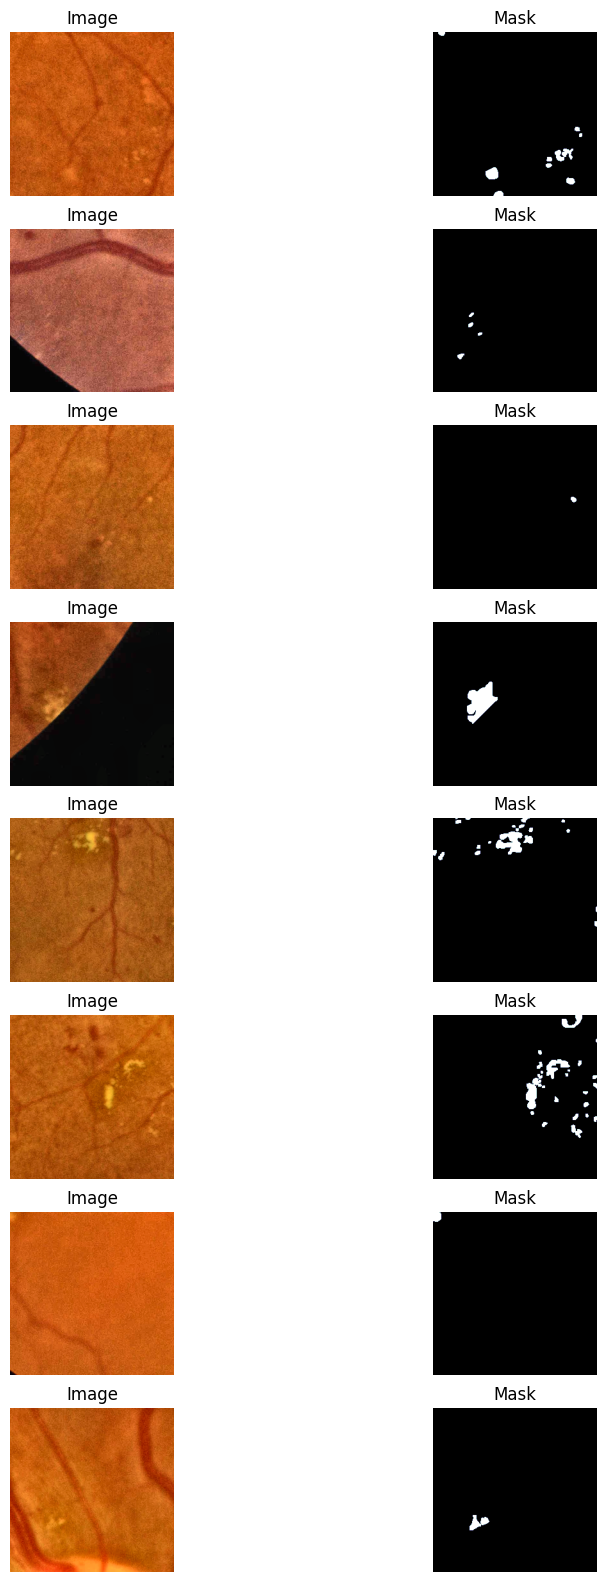

In [10]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, masks = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    #print(np.max(images[i]))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(masks[i], cmap='bone')
    #print(np.max(masks[i]))
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

df_shuffled = df_patches.sample(frac=1, random_state=42)
train_df, val_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)

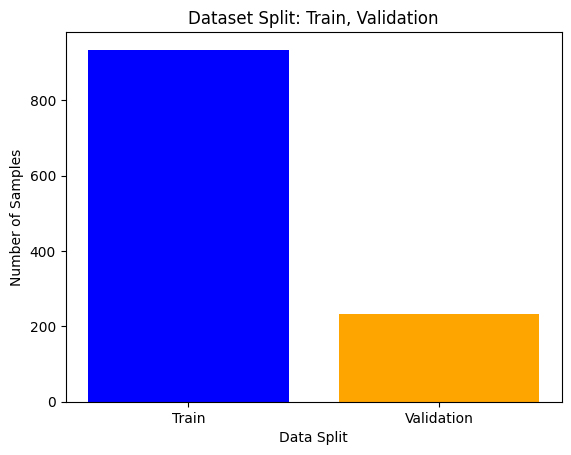

In [12]:
# bar plot
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']

plt.bar(labels, sizes, color=['blue', 'orange'])
plt.xlabel('Data Split')
plt.ylabel('Number of Samples')
plt.title('Dataset Split: Train, Validation')
plt.show()

In [13]:
#GCSE Block...from the GCSER UNET (Mukherjee et al.)
def GCSE(input_tensor, ratio=16):


    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)

    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)

    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)

    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])

    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])

    return output_tensor

Model Architecture and Helper Blocks

In [28]:
from tensorflow.keras.applications import ResNet50
def encoder1(inputs):


    """ Pre-trained ResNet50 Model """
    resnet50= ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    s = []
    for layer in resnet50.layers:
        layer.trainable = True


    """ Encoder """
    s1 = resnet50.get_layer("model_input").output           ## (512 x 512)
    s.append(s1)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s.append(s2)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s.append(s3)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    s.append(s4)

    """ Bridge """
    #b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)
    b1 = resnet50.get_layer("conv4_block2_out").output  ## (32 x 32)

    return b1,s

In [29]:
# Code for W-Net

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model


#Although may not use attention....GCSE seems to suffice
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    r = squeeze_excite_block(result_bn)

    return r

def gating_signal(input, out_size):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

"""def decoder_block(inputs, s1,s2, num_filters):

    g = gating_signal(inputs,num_filters)
    skip_features = Concatenate()([s1,s2])
    attn = attention_block(skip_features,g,num_filters)
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, attn])
    x = residual_block(x, num_filters)
    #x = squeeze_excite_block(x)
    return x"""

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x

def build_WNet(input_shape):
    s_1 = []
    f = [32,64,128,256]

    inputs = Input(input_shape,name="model_input")


    """inputs_1 = tf.keras.layers.RandomContrast(0.1)(inputs)
    inputs_1 = tf.keras.layers.RandomZoom(0.2)(inputs_1)"""

    x1,s_1 = encoder1(inputs)


    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    #p1 = DWT(wavelet_name="db1",concat=0,name = 'pool_1')(c1)
    #p1 = GCSE(p1)

    #s1 = residual_block(c1,f[0])
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    #p2 = DWT(wavelet_name="db1",concat=0,name = 'pool_2')(c2)
    #p2 = GCSE(p2)
    
    #s2 = residual_block(c2,f[1])
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    #p3 = DWT(wavelet_name="db1",concat=0,name = 'pool_3')(c3)
    #p3 = GCSE(p3)
    #s3 = residual_block(c3,f[2])
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    #p4 = DWT(wavelet_name="db1",concat=0,name = 'pool_4')(c4)
    #p4 = GCSE(p4)
    #s4 = residual_block(c4,f[3])
    s4 = c4

    """ Bridge """
    #c5  = residual_block(p4,256)
    b1 = ASPP(p4,128)
    b2 = ASPP(x1,128)
    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4,s_1[3], f[3])
    d2 = decoder_block(d1, s3,s_1[2], f[2])
    d3 = decoder_block(d2, s2,s_1[1], f[1])
    d4 = decoder_block(d3, s1,s_1[0],f[0])

    """ Classifier """
    outputs = Conv2D(1, (1,1) , activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [24]:
# Code for Network 1....for ablation
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y



def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    #x = squeeze_excite_block(x,8)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x

def build_Net1(input_shape):
    inputs = Input(input_shape)
    
    #integrating augmentation directly into the model
    #x = tf.keras.layers.RandomContrast(0.15)(inputs)
    #x = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
    #x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
    #x_ = tf.keras.layers.RandomZoom(0.3)(x)
    
    f = [16*2,32*2,64*2,128*2]
    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    #p1 = DWT(wavelet_name="db1",concat=0,name = 'pool_1')(c1)
    #s1 = residual_block(c1,32)
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    #p2 = DWT(wavelet_name="db1",concat=0,name = 'pool_2')(c2)
    #s2 = residual_block(c2,64)
    s2 = c2
    
    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    #p3 = DWT(wavelet_name="db1",concat=0,name = 'pool_3')(c3)
    #s3 = residual_block(c3,128)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    #p4 = DWT(wavelet_name="db1",concat=0,name = 'pool_4')(c4)
    #s4 = residual_block(c4,256)
    s4 = c4

    """ Bridge """
    b = ASPP(p4,128)
    #b = p4

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, f[3])
    d2 = decoder_block(d1, s3, f[2])
    d3 = decoder_block(d2, s2, f[1])
    d4 = decoder_block(d3, s1, f[0])

    """ Classifier """
    outputs = Conv2D(1, (1,1) , activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [29]:
from keras import backend as K
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.75, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
model = build_Net1((256,256,3))
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [18]:
model.compile(optimizer = adam, 
                  loss = total_loss, 
                  metrics = [iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]
                 )
#callbacks
csv_logger = CSVLogger('E:/IDRID_seg_dataset/HE_outputs/training_log_WCE_segmentation', separator=',', append=False)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=9
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="E:/IDRID_seg_dataset/HE_outputs/Net1_maxpool.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )
                              
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.0000001,
                              factor=0.3
                             )
callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger]

NameError: name 'model' is not defined

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

RuntimeError: Physical devices cannot be modified after being initialized

In [ ]:
batch_size = 4
N=256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)

history = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=100,callbacks=callbacks)


Epoch 1/100
233/233 [==============================] - ETA: 0s - loss: 0.5508 - iou_score: 0.2488 - dice_coeff: 0.4822 - precision: 0.5589 - recall: 0.4897 - sensitivity: 0.5594 - specificity: 0.9885 - auc: 0.8237
Epoch 1: val_loss improved from inf to 1.05275, saving model to E:/IDRID_seg_dataset/HE_outputs\Net1_maxpool.h5
233/233 [==============================] - 86s 293ms/step - loss: 0.5508 - iou_score: 0.2488 - dice_coeff: 0.4822 - precision: 0.5589 - recall: 0.4897 - sensitivity: 0.5594 - specificity: 0.9885 - auc: 0.8237 - val_loss: 1.0527 - val_iou_score: 6.6184e-04 - val_dice_coeff: 0.0021 - val_precision: 1.0000 - val_recall: 2.6078e-04 - val_sensitivity: 1.3675e-04 - val_specificity: 1.0000 - val_auc: 0.5068 - lr: 0.0010
Epoch 2/100
233/233 [==============================] - ETA: 0s - loss: 0.4360 - iou_score: 0.3214 - dice_coeff: 0.5914 - precision: 0.7005 - recall: 0.5942 - sensitivity: 0.6472 - specificity: 0.9924 - auc: 0.8754
Epoch 2: val_loss improved from 1.05275 to 

In [ ]:
history.history.keys()

dict_keys(['loss', 'iou_score', 'dice_coeff', 'precision', 'recall', 'sensitivity', 'specificity', 'auc', 'val_loss', 'val_iou_score', 'val_dice_coeff', 'val_precision', 'val_recall', 'val_sensitivity', 'val_specificity', 'val_auc', 'lr'])

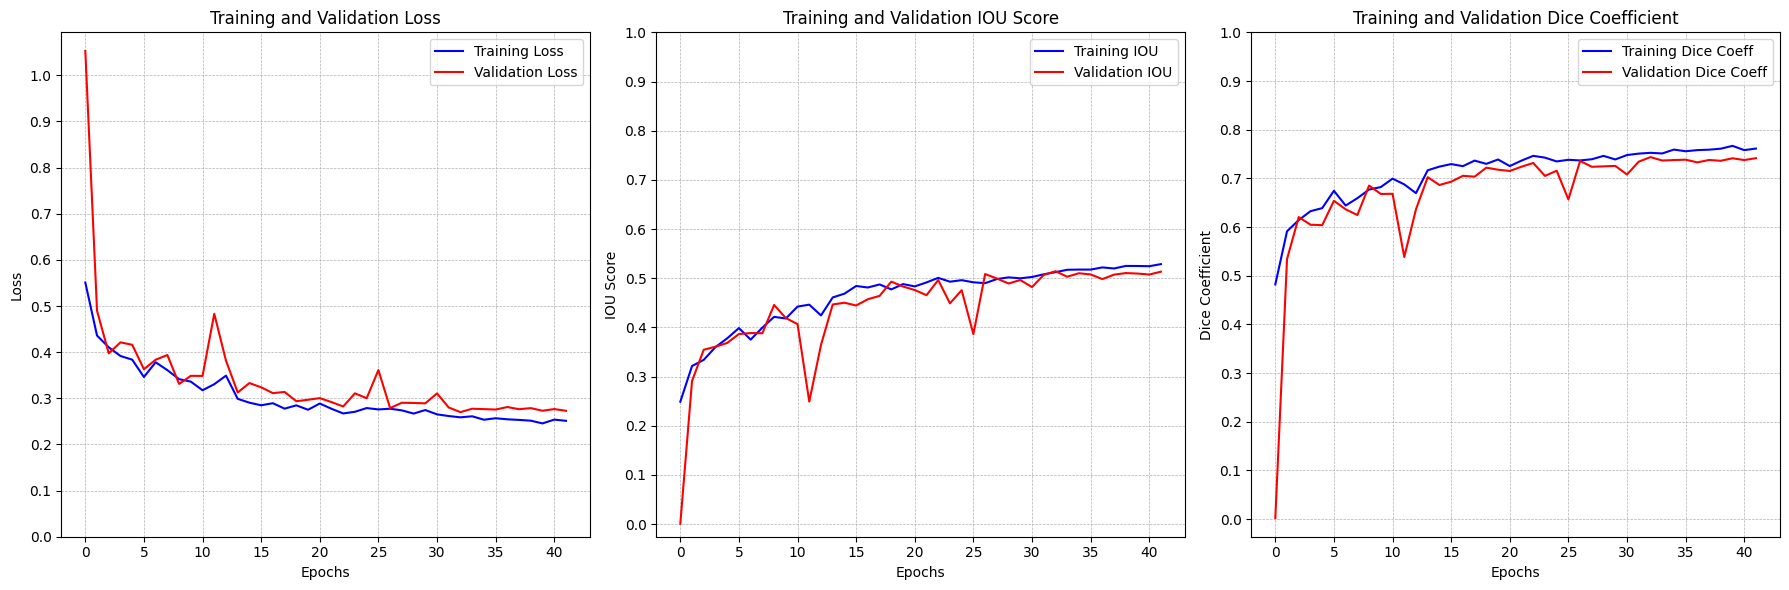

In [ ]:
from matplotlib import pyplot as plt
#history = pd.read_csv('/kaggle/input/brats-slices-0-05-model-and-log-tc/training_log_tc', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history.history['iou_score']
val_iou_score=history.history['val_iou_score']

loss=history.history['loss']
val_loss=history.history['val_loss']

train_dice=history.history['dice_coeff']
val_dice=history.history['val_dice_coeff']

epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Preparing Testing Data

In [20]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "E:/IDRID_seg_dataset//HE_patches_test/image_patches_512_no_overlap"
mask_patch_folder = "E:/IDRID_seg_dataset//HE_patches_test/mask_patches_512_no_overlap"

# Read patch paths and create a DataFrame
df_patches_test = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 456/456 [00:00<00:00, 7583.34it/s]


In [40]:

import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            #augmented = self.transform(image=image, mask=mask)
            #images.append(augmented['image'])
            #masks.append(augmented['mask'])
            images.append(image)
            masks.append(mask)
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
test_generator = CustomDataGenerator(df_patches_test, batch_size=16, image_size=(256, 256), shuffle=False)

In [41]:
model = build_Net1((256,256,3))

In [42]:
model.load_weights("E:/IDRID_seg_dataset/HE_outputs/Net1_maxpool.h5")
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                  loss = total_loss, 
                  metrics = [iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]
                 )

In [43]:
results = model.evaluate(test_generator,verbose=1)

29/29 [==============================] - 10s 245ms/step - loss: 0.2773 - iou_score: 0.5038 - dice_coeff: 0.7353 - precision_3: 0.7585 - recall_3: 0.8455 - sensitivity: 0.8109 - specificity: 0.9909 - auc_3: 0.9610
